In [1]:
!pip install -q kagglehub albumentations

import kagglehub
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-02 05:02:29.854542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746162150.123704      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746162150.202644      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = kagglehub.dataset_download('ashishmotwani/tomato')
print("Dataset downloaded to:", dataset_path)

Dataset downloaded to: /kaggle/input/tomato


In [3]:
# List the contents of the downloaded dataset directory
print("Contents of the dataset directory:")
print(os.listdir(dataset_path))

Contents of the dataset directory:
['valid', 'train']


In [4]:
TRAIN_DIR = os.path.join(dataset_path, 'train')
VAL_DIR = os.path.join(dataset_path, 'valid')

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

class_names = list(train_generator.class_indices.keys())

print("Classes:", class_names)

Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [6]:
base_model = EfficientNetB0(
    include_top=False,               # Remove default classification head
    weights='imagenet',             # Use pretrained weights
    input_shape=(224, 224, 3)       # Input shape (match our image size)
)


base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

2025-05-02 05:03:01.468130: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


808/808 ━━━━━━━━━━━━━━━━━━━━ 1271s 2s/step - accuracy: 0.1141 - loss: 2.3742 - val_accuracy: 0.1185 - val_loss: 2.3557
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 1222s 2s/step - accuracy: 0.1152 - loss: 2.3606 - val_accuracy: 0.1185 - val_loss: 2.3560
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 1230s 2s/step - accuracy: 0.1241 - loss: 2.3585 - val_accuracy: 0.1205 - val_loss: 2.3553
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 1255s 2s/step - accuracy: 0.1222 - loss: 2.3589 - val_accuracy: 0.1185 - val_loss: 2.3558
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 1238s 2s/step - accuracy: 0.1161 - loss: 2.3599 - val_accuracy: 0.1185 - val_loss: 2.3553
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 1242s 2s/step - accuracy: 0.1179 - loss: 2.3591 - val_accuracy: 0.1205 - val_loss: 2.3554
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 1229s 2s/step - accuracy: 0.1148 - loss: 2.3623 - val_accuracy: 0.1185 - val_loss: 2.3551
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 1237s 2s/step - accuracy: 0.1207 - loss: 2.3586 - val_accurac

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

209/209 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.1177 - loss: 2.3574
Validation Accuracy: 0.12
Validation Loss: 2.36


In [8]:
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_names))

209/209 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.00      0.00      0.00       732
                        Early_blight       0.00      0.00      0.00       643
                         Late_blight       0.12      1.00      0.21       792
                           Leaf_Mold       0.00      0.00      0.00       739
                  Septoria_leaf_spot       0.00      0.00      0.00       746
Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00       435
                         Target_Spot       0.00      0.00      0.00       457
       Tomato_Yellow_Leaf_Curl_Virus       0.00      0.00      0.00       498
                 Tomato_mosaic_virus       0.00      0.00      0.00       584
                             healthy       0.00      0.00      0.00       805
                      powdery_mildew       0.00      0.00      0.00       252

                    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


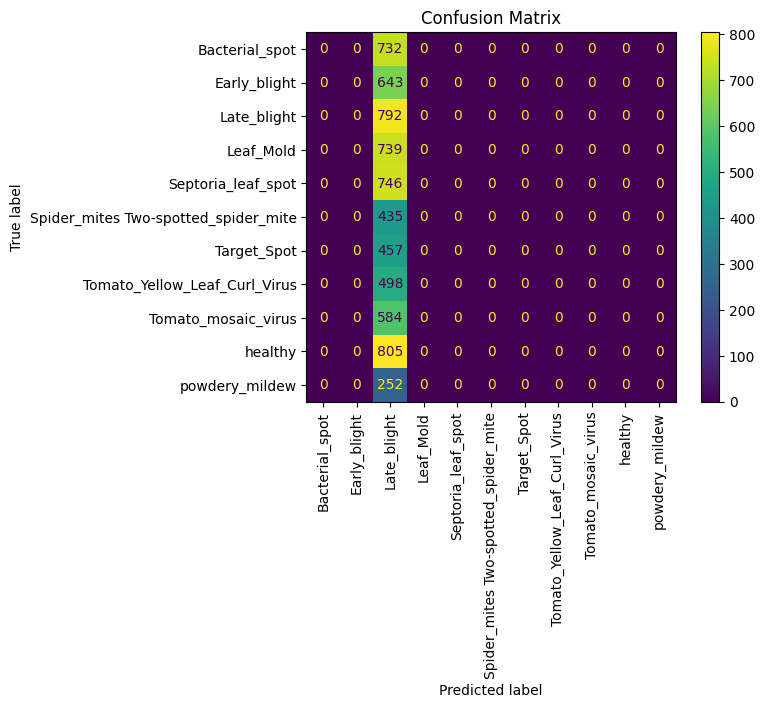

In [9]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=90)
plt.title('Confusion Matrix')
plt.show()